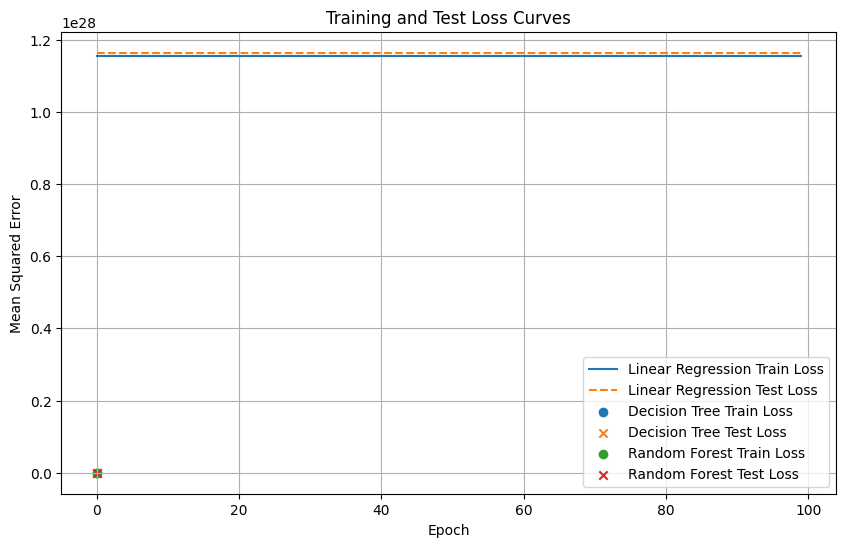

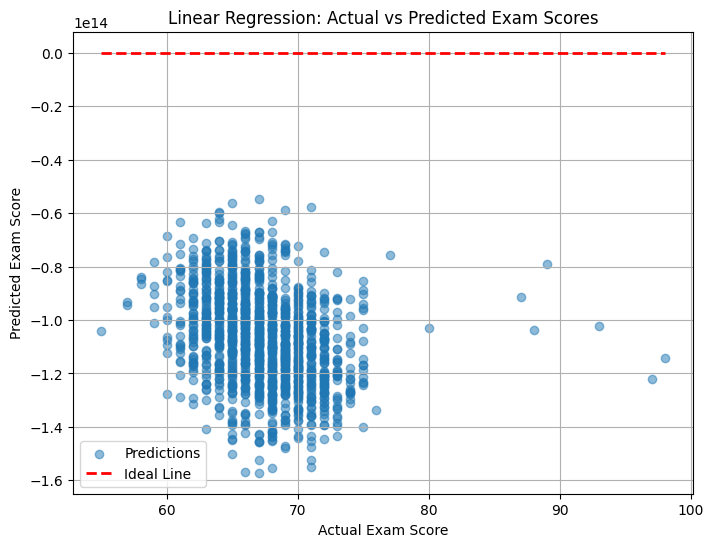


Model Comparison:
Linear Regression:
  MSE: 11635176447483435717803114496.00
  R2: -823142326978681651115065344.00
Decision Tree:
  MSE: 11.31
  R2: 0.20
Random Forest:
  MSE: 5.76
  R2: 0.59
  (Best Model)


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import joblib

# Load the CSV file
data = pd.read_csv('StudentPerformanceFactors.csv')

# Drop excluded features
excluded_features = ['Family_Income', 'Parental_Involvement', 'Physical_Activity', 'Distance_from_Home',
                     'Motivation_Level', 'Tutoring_Sessions', 'Parental_Education_Level']
data = data.drop(columns=excluded_features)

# Feature constraints for remaining features
feature_constraints = {
    'Hours_Studied': {'type': 'numerical', 'min': 0, 'max': 50},
    'Attendance': {'type': 'numerical', 'min': 0, 'max': 100},
    'Access_to_Resources': {'type': 'categorical', 'values': ['Low', 'Medium', 'High']},
    'Extracurricular_Activities': {'type': 'categorical', 'values': ['Yes', 'No']},
    'Sleep_Hours': {'type': 'numerical', 'min': 0, 'max': 24},
    'Previous_Scores': {'type': 'numerical', 'min': 0, 'max': 100},
    'Internet_Access': {'type': 'categorical', 'values': ['Yes', 'No']},
    'Teacher_Quality': {'type': 'categorical', 'values': ['Low', 'Medium', 'High']},
    'School_Type': {'type': 'categorical', 'values': ['Public', 'Private']},
    'Peer_Influence': {'type': 'categorical', 'values': ['Positive', 'Negative', 'Neutral']},
    'Learning_Disabilities': {'type': 'categorical', 'values': ['Yes', 'No']},
    'Gender': {'type': 'categorical', 'values': ['Male', 'Female']}
}

# Define numerical and categorical columns
numerical_cols = [col for col, spec in feature_constraints.items() if spec['type'] == 'numerical']
categorical_cols = [col for col, spec in feature_constraints.items() if spec['type'] == 'categorical']

# Define preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

# Split features and target
X = data.drop('Exam_Score', axis=1)
y = data['Exam_Score']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize models
models = {
    'Linear Regression': Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', SGDRegressor(max_iter=100, tol=None, learning_rate='constant', eta0=0.01, random_state=42))
    ]),
    'Decision Tree': Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', DecisionTreeRegressor(random_state=42))
    ]),
    'Random Forest': Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
    ])
}

# Train models and collect performance metrics
results = {}
train_losses = {'Linear Regression': [], 'Decision Tree': [], 'Random Forest': []}
test_losses = {'Linear Regression': [], 'Decision Tree': [], 'Random Forest': []}

for name, model in models.items():
    if name == 'Linear Regression':
        # Simulate epochs for SGDRegressor
        n_epochs = 100
        for epoch in range(n_epochs):
            model.fit(X_train, y_train)
            y_train_pred = model.predict(X_train)
            y_test_pred = model.predict(X_test)
            train_losses[name].append(mean_squared_error(y_train, y_train_pred))
            test_losses[name].append(mean_squared_error(y_test, y_test_pred))
    else:
        # Train Decision Tree and Random Forest
        model.fit(X_train, y_train)
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
        train_losses[name].append(mean_squared_error(y_train, y_train_pred))
        test_losses[name].append(mean_squared_error(y_test, y_test_pred))

    # Final performance metrics
    y_test_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_test_pred)
    r2 = r2_score(y_test, y_test_pred)
    results[name] = {'MSE': mse, 'R2': r2, 'model': model}

# Save the best model
best_model_name = min(results, key=lambda x: results[x]['MSE'])
best_model = results[best_model_name]['model']
joblib.dump(best_model, 'best_model.pkl')

# Plot loss curves
plt.figure(figsize=(10, 6))
for name in models.keys():
    if name == 'Linear Regression':
        plt.plot(range(n_epochs), train_losses[name], label=f'{name} Train Loss')
        plt.plot(range(n_epochs), test_losses[name], label=f'{name} Test Loss', linestyle='--')
    else:
        plt.scatter([0], train_losses[name], label=f'{name} Train Loss', marker='o')
        plt.scatter([0], test_losses[name], label=f'{name} Test Loss', marker='x')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.title('Training and Test Loss Curves')
plt.legend()
plt.grid(True)
plt.savefig('loss_curves.png')
plt.show()

# Plot scatter plot for Linear Regression
lr_model = models['Linear Regression']
y_test_pred_lr = lr_model.predict(X_test)
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred_lr, alpha=0.5, label='Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Ideal Line')
plt.xlabel('Actual Exam Score')
plt.ylabel('Predicted Exam Score')
plt.title('Linear Regression: Actual vs Predicted Exam Scores')
plt.legend()
plt.grid(True)
plt.savefig('lr_scatter.png')
plt.show()

# Compare models
print("\nModel Comparison:")
for name, metrics in results.items():
    print(f"{name}:")
    print(f"  MSE: {metrics['MSE']:.2f}")
    print(f"  R2: {metrics['R2']:.2f}")
    if name == best_model_name:
        print("  (Best Model)")